# Prepare on the fly data loader

In [66]:
import os
import cv2
from typing import Dict

import h5py
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader as TorchDataLoader

line_data_hdf5_file = '/Users/kelchtermans/data/vanilla_3x128x128.hdf5' 
line_data = h5py.File(line_data_hdf5_file, "r", libver="latest", swmr=True)

In [118]:
class LineDataset(TorchDataset):

    def __init__(self, line_data_hdf5_file: str = '/Users/kelchtermans/data/vanilla_128x128x3_pruned.hdf5',
                 background_images_directory: str = '/Users/kelchtermans/data/textured_dataset'):
        self.hdf5_file = h5py.File(line_data_hdf5_file, "r", libver="latest", swmr=True)
        self.observations = self.hdf5_file['dataset']['observations']
        self.background_images = [os.path.join(background_images_directory, sub_directory, image)
            for sub_directory in os.listdir(background_images_directory)
            if os.path.isdir(os.path.join(background_images_directory, sub_directory))
            for image in os.listdir(os.path.join(background_images_directory, sub_directory))
            if image.endswith('.jpg')]
        self._size = len(self.observations)

    def __len__(self) -> int:
        return self._size

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        result = {}
        # 128x128x3
        image = self.observations[index]

        # create binary mask as target: 128x128
        result['target'] = get_binary_mask(image)

        # select foreground color and background map
        background_img = load_img(
            np.random.choice(self.background_images),
            size=image.shape)
        foreground_img = np.zeros(image.shape)
        foreground_img[:, :, 0] = np.random.uniform(0, 1)
        foreground_img[:, :, 1] = np.random.uniform(0, 1)
        foreground_img[:, :, 2] = np.random.uniform(0, 1)

        # combine both as reference image
        result['reference'] = combine(result['target'], foreground_img, background_img)
        
        # add different background for positive sample
        new_background_img = load_img(
            np.random.choice(self.background_images),
            size=image.shape)
        result['positive'] = combine(result['target'], foreground_img, new_background_img)
        
        # get different line with different background for negative sample
        random_other_index = index
        # make sure new index is at least 5 frames away
        while abs(random_other_index - index) < 5:
            random_other_index = np.random.randint(0, self._size)

        new_image = self.observations[random_other_index]
        result['negative'] = combine(get_binary_mask(new_image), foreground_img, background_img)
        return result

def load_img(img_path: str, size: tuple = (128, 128, 3)) -> np.ndarray:
    data = Image.open(img_path, mode='r')
    data = cv2.resize(np.asarray(data), dsize=(size[0], size[1]), interpolation=cv2.INTER_LANCZOS4)
    if size[-1] == 1:
        data = data.mean(axis=-1, keepdims=True)
    data = np.array(data).astype(np.float32)/255.  # uint8 -> float32
    return data

def combine(mask: np.ndarray, foreground: np.ndarray, background: np.ndarray) -> np.ndarray:
    combination = mask * foreground + (1 - mask) * background
    return combination

def plot(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def get_binary_mask(image: np.ndarray) -> np.ndarray:
    return np.expand_dims(
            cv2.threshold(image.mean(axis=-1), 0.5, 1, cv2.THRESH_BINARY_INV)[1], axis=-1)


def create_random_gradient_image(size: tuple, low: float = 0., high: float = 1.) -> np.ndarray:
    color_a = np.random.uniform(low, high)
    color_b = np.random.uniform(low, high)
    locations = (np.random.randint(size[0]), np.random.randint(size[0]))
    while locations[0] == locations[1]:
        locations = (np.random.randint(size[0]), np.random.randint(size[0]))
    x1, x2 = min(locations), max(locations)
    gradient = np.arange(color_a, color_b, ((color_b - color_a)/(x2 - x1)))
    gradient = gradient[:x2-x1]
    assert len(gradient) == x2 - x1, f'failed: {len(gradient)} vs {x2 - x1}'
    vertical_gradient = np.concatenate([np.ones(x1) * color_a, gradient, np.ones(size[0] - x2) * color_b])
    image = np.stack([vertical_gradient]*size[1], axis=1).reshape(size)
    return image

In [93]:
old_hdf5_file = h5py.File('/Users/kelchtermans/data/vanilla_3x128x128.hdf5', "r", libver="latest", swmr=True)
old_dataset = old_hdf5_file['dataset']['observations']

pruned_hdf5_file = h5py.File('/Users/kelchtermans/data/vanilla_128x128x3_pruned.hdf5', "w", libver="latest", swmr=True)
pruned_dataset = pruned_hdf5_file.create_group('dataset')
pruned_dataset['observations'] = np.stack(
    [
        _.swapaxes(0, 1).swapaxes(1, 2) 
        for _ in old_dataset
        if np.sum(get_binary_mask(_.swapaxes(0, 1).swapaxes(1, 2))) > 250
    ]
)
pruned_hdf5_file.close()

In [90]:
counts = [np.sum(get_binary_mask(_)) for _ in dataset.line_data['dataset']['observations']]

(array([3.100e+02, 1.830e+02, 4.250e+02, 2.900e+03, 3.503e+03, 1.616e+03,
        4.450e+02, 9.900e+01, 1.000e+01, 3.000e+00]),
 array([121. , 162.9, 204.8, 246.7, 288.6, 330.5, 372.4, 414.3, 456.2,
        498.1, 540. ], dtype=float32),
 <BarContainer object of 10 artists>)

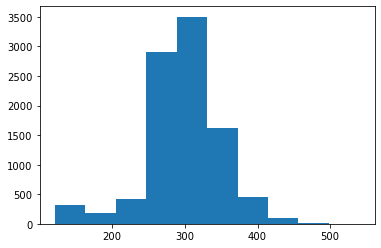

In [91]:
plt.hist(counts)

target


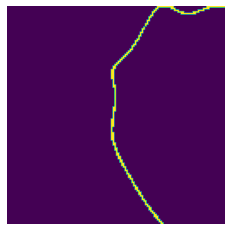

reference


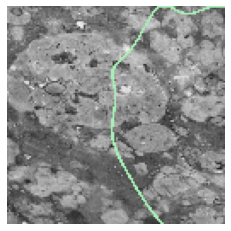

positive


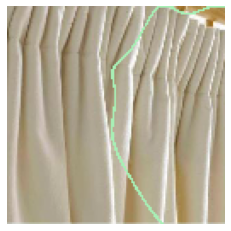

negative


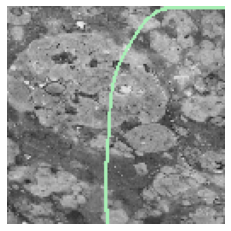

In [119]:
dataset = LineDataset()
result = dataset[0]
for k, v in result.items():
    print(k)
    plot(v)

8464